In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

from wordcloud import WordCloud, STOPWORDS

from collections import Counter
from collections import defaultdict

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation
from keras.utils import pad_sequences

import pickle

In [3]:
data = pd.read_csv('IMDB Dataset.csv')

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Initial Data Analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
data_copy = data.copy()

In [7]:
le = LabelEncoder()

data_copy = data_copy.dropna(subset=["sentiment"])
data_copy["Score"] = le.fit_transform(data_copy['sentiment'])

In [8]:
data_copy["Score"].unique()

array([1, 0])

## EDA & Data Pre-processing

In [9]:
def clean_data(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub(r'[^a-zA-z0-9\s]','',text)
    return text

In [10]:
data_copy['review']=data_copy['review'].apply(clean_data)

D:\Anaconda\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [11]:
data_copy.head()

,review,sentiment,Score
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production The filming tech...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically theres a family where a little boy J...,negative,0
4,Petter Matteis Love in the Time of Money is a ...,positive,1


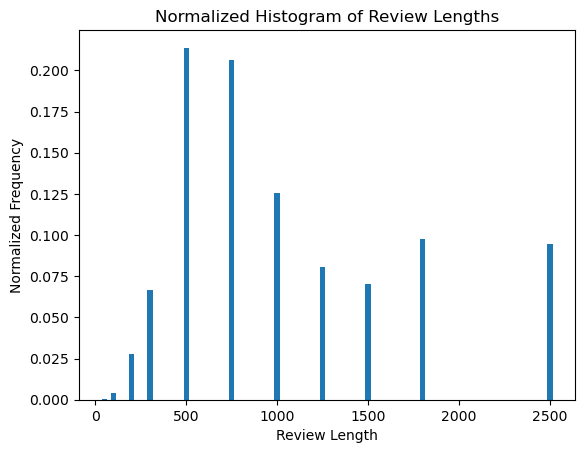

In [12]:
# Compute the lengths of the reviews
review_lengths = data['review'].str.len()

# Specify the bin edges for the histogram
bin_edges = [50, 100, 200, 300, 500, 750, 1000, 1250, 1500, 1800, 2500, 5000]

# Compute the histogram and normalize the frequency
hist, _ = np.histogram(review_lengths, bins=bin_edges)
freq = hist / len(review_lengths)

# Plot the normalized histogram
plt.bar(bin_edges[:-1], freq, width=30)
plt.xlabel('Review Length')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Histogram of Review Lengths')
plt.show()

In [13]:
# Uncomment below to Download the required NLTK data
#nltk.download()

# Load the stopwords
stop = set(stopwords.words('english'))
stopword_list = list(stop)
stopword_list.sort()

Text(0.5, 1.0, 'Histogram of stop words')

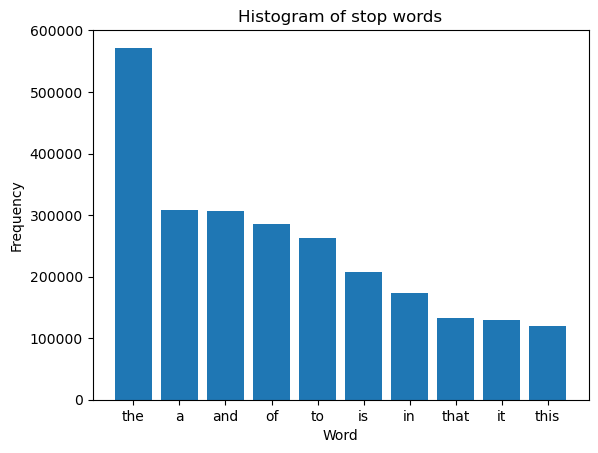

In [14]:
corpus=[]

re = data_copy['review'].str.split()

re =re.values.tolist()

corpus = [word for i in re for word in i]


dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Histogram of stop words')

Text(0.5, 1.0, 'Histogram of frequent words')

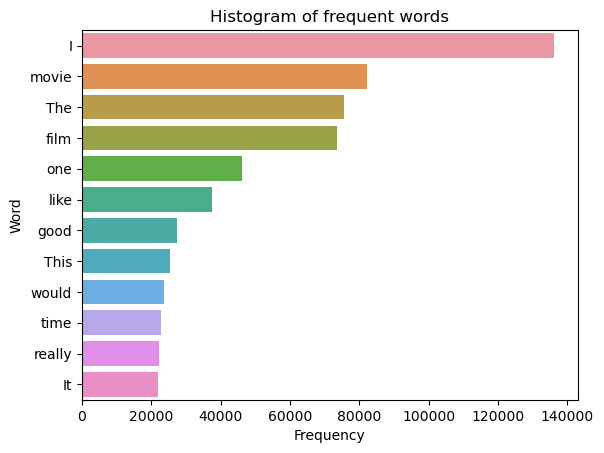

In [17]:
counter=Counter(corpus)
most=counter.most_common()
x, y=[], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
            
sns.barplot(x=y,y=x)
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Histogram of frequent words')

In [18]:
df = data_copy

In [19]:
df

,review,sentiment,Score
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production The filming tech...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically theres a family where a little boy J...,negative,0
4,Petter Matteis Love in the Time of Money is a ...,positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,Bad plot bad dialogue bad acting idiotic direc...,negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,Im going to have to disagree with the previous...,negative,0


Text(0, 0.5, 'Count')

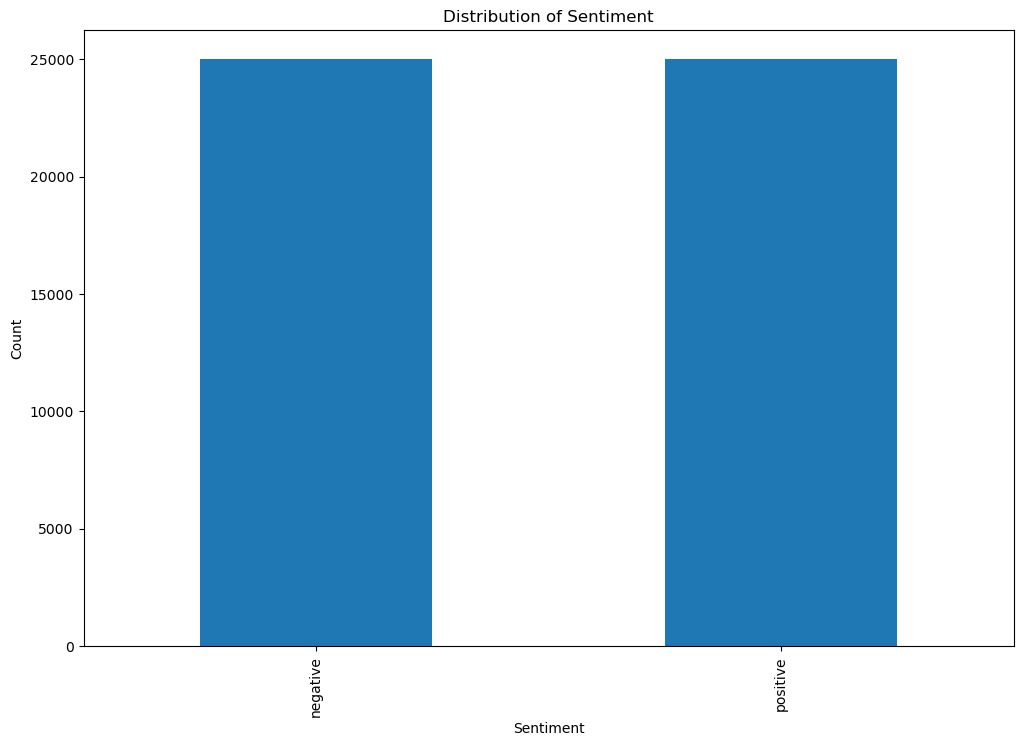

In [20]:
# Plot distribution of Score
plt.figure(figsize=(12,8))
df['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

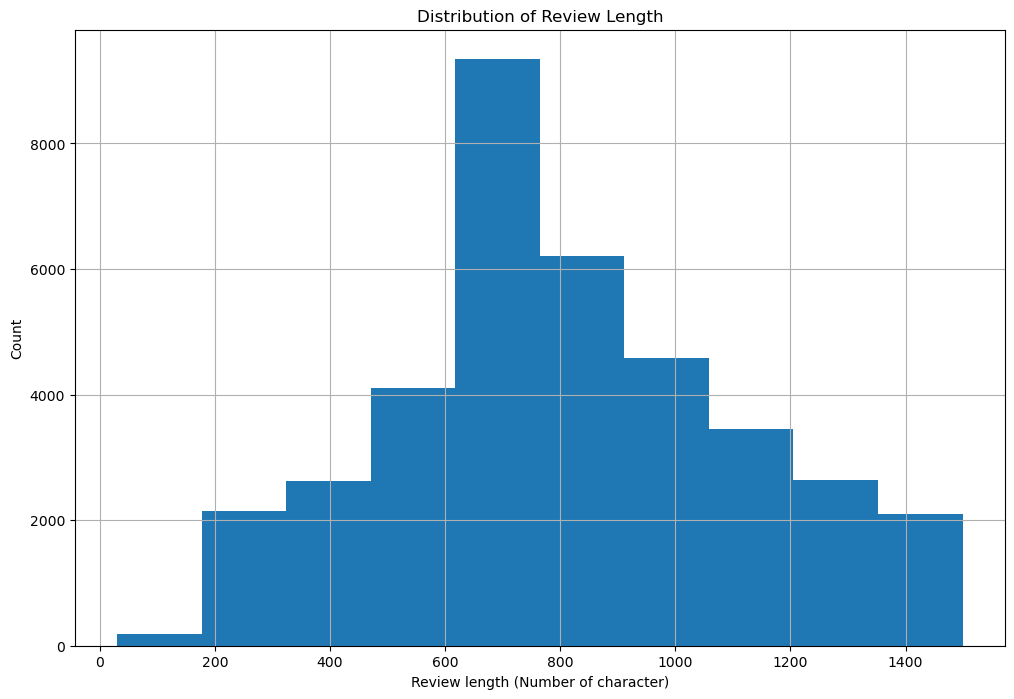

In [21]:
# Plot distribution of review length
review_length = df["review"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

## Model Training

In [22]:
# training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['Score'],test_size=0.25, random_state=42)

In [23]:
# Bag of words model

import re

def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [24]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []
X_all = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
    X_all.append(cleanText(d))

    
for d in X_test:
    X_test_cleaned.append(cleanText(d))
    X_all.append(cleanText(d))

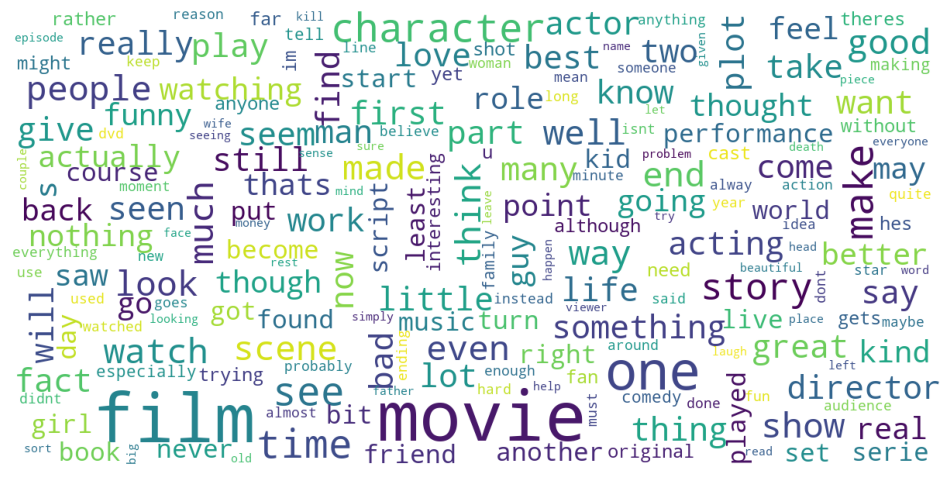

In [57]:
wordcloud = WordCloud(background_color='white',stopwords=set(STOPWORDS),
                      max_font_size=30,scale=3,random_state=1)
    
wordcloud=wordcloud.generate(str(X_all))

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
 
plt.imshow(wordcloud)
plt.show()

In [26]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)

# TFIDF 
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)

In [33]:
with open('tfidf_vectorizer.sav', 'wb') as f:
    pickle.dump(tfidf, f)

## 1. Multinomial Naive Bayes

In [34]:
# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

MultinomialNB()

In [35]:
predictionsnb = mnb.predict(countVect.transform(X_test_cleaned))

print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictionsnb)))
print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictionsnb)))
print("\nClassification report : \n", metrics.classification_report(y_test, predictionsnb))
#print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictionsnb))


Accuracy on validation set: 0.8476

AUC score : 0.8481

Classification report : 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      6157
           1       0.87      0.82      0.84      6343

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500



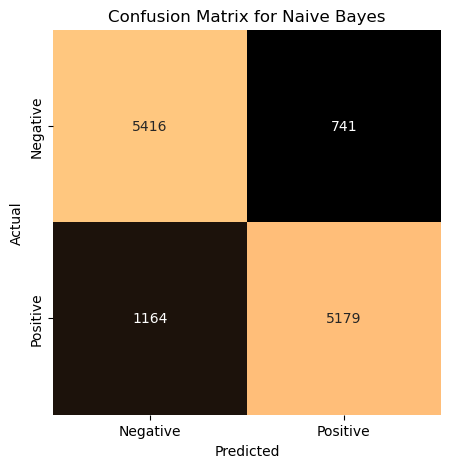

In [36]:
confusionnb = metrics.confusion_matrix(y_test, predictionsnb)
#sns.heatmap(cm,annot = True, cmap = 'magma',fmt = 'g')
plt.figure(figsize = (5,5))
sns.heatmap(confusionnb, annot = True, fmt = 'g', cbar = False,cmap = 'copper')
plt.xticks(ticks = [0.5,1.5], labels = ['Negative', 'Positive'])
plt.yticks(ticks = [0.5,1.5], labels= ['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

## 2. Random Forest

In [37]:
rf = RandomForestClassifier(n_estimators=100, random_state=1)

rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=1)

In [38]:
predictionsrf = rf.predict(tfidf.transform(X_test_cleaned))

print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictionsrf)))
print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictionsrf)))
print("\nClassification report : \n", metrics.classification_report(y_test, predictionsrf))
#print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictionsrf))


Accuracy on validation set: 0.8495

AUC score : 0.8497

Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      6157
           1       0.86      0.84      0.85      6343

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500



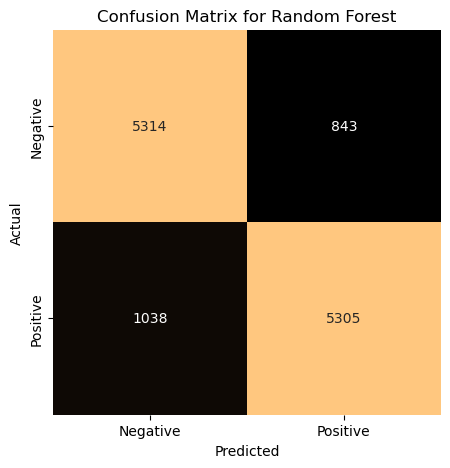

In [39]:
confusionrf = metrics.confusion_matrix(y_test, predictionsrf)
#sns.heatmap(cm,annot = True, cmap = 'magma',fmt = 'g')
plt.figure(figsize = (5,5))
sns.heatmap(confusionrf, annot = True, fmt = 'g', cbar = False,cmap = 'copper')
plt.xticks(ticks = [0.5,1.5], labels = ['Negative', 'Positive'])
plt.yticks(ticks = [0.5,1.5], labels= ['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

## 3. Logistic Regression

In [40]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

LogisticRegression()

In [41]:
predictionslr = lr.predict(tfidf.transform(X_test_cleaned))

print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictionslr)))
print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictionslr)))
print("\nClassification report : \n", metrics.classification_report(y_test, predictionslr))
#print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictionslr))


Accuracy on validation set: 0.8982

AUC score : 0.8980

Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      6157
           1       0.89      0.91      0.90      6343

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500



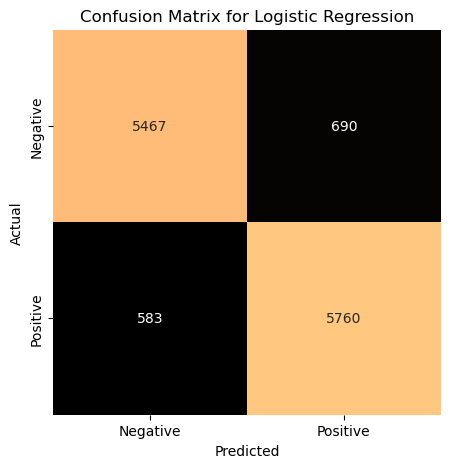

In [42]:
confusionlr = metrics.confusion_matrix(y_test, predictionslr)
#sns.heatmap(cm,annot = True, cmap = 'magma',fmt = 'g')
plt.figure(figsize = (5,5))
sns.heatmap(confusionlr, annot = True, fmt = 'g', cbar = False,cmap ='copper')
plt.xticks(ticks = [0.5,1.5], labels = ['Negative', 'Positive'])
plt.yticks(ticks = [0.5,1.5], labels= ['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [43]:
#Naive Bayes

#new_review = "I really enjoyed this movie. The acting was great and the story kept me engaged."
#new_review = 'The movie was very bad, wasted my time.' 
new_review = 'A wonderful little production. <br /><br />The...html..[/a] '

new_r = countVect.transform([new_review])
# Make a prediction
prediction = mnb.predict(new_r)

# Print the predicted sentiment label

if prediction == 0:
    print("Negative Review")
else:
    print("Positive Review")

Positive Review


In [44]:
# LOGISTIC Regression

new_review = "I really enjoyed this movie. The acting was great and the story kept me engaged."
#new_review = 'The movie was very bad, wasted my time.' 

#vectorizer = CountVectorizer(stop_words='english')
#X_train_countVect = countVect.fit_transform(X_train_cleaned)
#new_review_vectorized = vectorizer.fit_transform(new_review)
new_r = tfidf.transform([new_review])
# Make a prediction
prediction = lr.predict(new_r)

# Print the predicted sentiment label

if prediction == 0:
    print("Negative Review")
else:
    print("Positive Review")

Positive Review


## 4. Xgboost

In [54]:
modelx = xgb.XGBClassifier()
modelx.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [55]:
predictionsx = modelx.predict(tfidf.transform(X_test_cleaned))

print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
#print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))


Accuracy on validation set: 0.9000

AUC score : 0.8999

Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      6157
           1       0.90      0.91      0.90      6343

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500



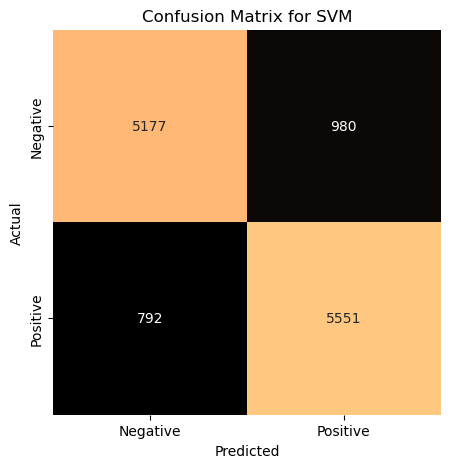

In [47]:
confusionx = metrics.confusion_matrix(y_test, predictionsx)
#sns.heatmap(cm,annot = True, cmap = 'magma',fmt = 'g')
plt.figure(figsize = (5,5))
sns.heatmap(confusionx, annot = True, fmt = 'g', cbar = False,cmap = 'copper')
plt.xticks(ticks = [0.5,1.5], labels = ['Negative', 'Positive'])
plt.yticks(ticks = [0.5,1.5], labels= ['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()

## 5. Support Vector Machine(SVM)

In [48]:
#baseline model
svm_model1 = LinearSVC()
svm_model1.fit(X_train_tfidf, y_train)

predictions = svm_model1.predict(tfidf.transform(X_test_cleaned))

print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))


Accuracy on validation set: 0.9000

AUC score : 0.8999

Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      6157
           1       0.90      0.91      0.90      6343

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500


Confusion Matrix : 
 [[5505  652]
 [ 598 5745]]


In [43]:
# Hyper parameter Tuning

params = {
    'penalty': ['l1', 'l2'],
    "C": [0.1,0.5, 1, 10,50,100],
    "loss": ["hinge", "squared_hinge"],
    "max_iter": [500, 1000, 2000],
}

grid_search = GridSearchCV(svm_model1, params, cv=5, n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(tfidf.transform(X_test_cleaned))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

D:\Anaconda\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "D:\Anaconda\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalt

Best hyperparameters: {'C': 0.5, 'loss': 'squared_hinge', 'max_iter': 500, 'penalty': 'l2'}
Best score: 0.89696
Accuracy: 0.90248


In [28]:
svm_model = LinearSVC(C= 0.5, loss= 'squared_hinge', max_iter= 500,penalty = 'l2')
svm_model.fit(X_train_tfidf, y_train)


# saving the model to use in streamlit
with open('svm_model.sav', 'wb') as f:
    pickle.dump(svm_model, f)

In [29]:
predictions = svm_model.predict(tfidf.transform(X_test_cleaned))

print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
#print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))


Accuracy on validation set: 0.9025

AUC score : 0.9024

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      6157
           1       0.90      0.91      0.90      6343

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500



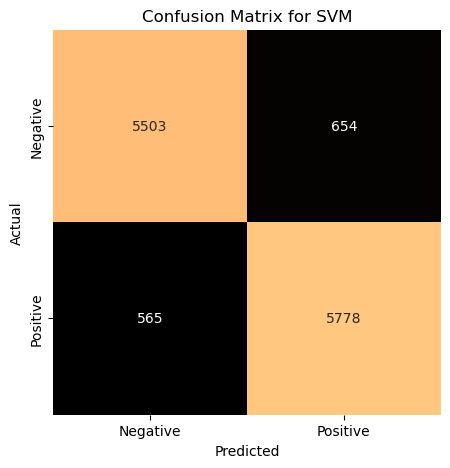

In [30]:
confusion = metrics.confusion_matrix(y_test, predictions)
#sns.heatmap(cm,annot = True, cmap = 'magma',fmt = 'g')
plt.figure(figsize = (5,5))
sns.heatmap(confusion, annot = True, fmt = 'g', cbar = False,cmap = 'copper')
plt.xticks(ticks = [0.5,1.5], labels = ['Negative', 'Positive'])
plt.yticks(ticks = [0.5,1.5], labels= ['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()

In [49]:
#new_review = "I really enjoyed this movie. The acting was great and the story kept me engaged."
new_review = 'The movie was very bad, wasted my time.' 

#vectorizer = CountVectorizer(stop_words='english')
#X_train_countVect = countVect.fit_transform(X_train_cleaned)
#new_review_vectorized = vectorizer.fit_transform(new_review)
new_r = tfidf.transform([new_review])
# Make a prediction
prediction = svm_model.predict(new_r)

# Print the predicted sentiment label

if prediction == 0:
    print("Negative Review")
else:
    print("Positive Review")

Negative Review


## 6. Long Short Term Memory(LSTM)

In [55]:
# LSTM

top_words = 20000 
maxlen = 100 
batch_size = 16
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words)
tokenizer.fit_on_texts(X_train)


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)



X_train_seq = pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)


D:\Anaconda\anaconda3\lib\site-packages\keras\preprocessing\text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


X_train shape: (37500, 100)
X_test shape: (12500, 100)
y_train shape: (37500, 2)
y_test shape: (12500, 2)


In [56]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128))
#model1.add(Embedding(top_words, 64))
model1.add(LSTM(128)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax')) # relu,tanh
# add learning rate
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#optimizer - change

#model1.fit(X_train_seq, y_train_seq, batch_size=batch_size,  verbose=1)

#model_name = 'LSTM_Mod.h5'
#file_path = 'E:\MSU\Classes\CMSE_890\Project\'

# save model
#model1.save(file_path + model_name)

# Model evluation
#score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
#print('Test loss : {:.4f}'.format(score[0]))
#print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
 activation_3 (Activation)   (None, 2)                 0         
                                                                 
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
2344/2344 [==============================] - 262s 110ms/step - loss: 0.4066 - accuracy: 0.8191 - val_loss: 0.3168 - val_accuracy: 0.8652
Epoch 2/5
2344/2344 [==============================] - 241s 103ms/step - loss: 0.2380 - accuracy: 0.9060 - val_loss: 0.3298 - val_accuracy: 0.8663
Epoch 3/5
2344/2344 [==============================] - 276s 118ms/step - loss: 0.1572 - accuracy: 0.9424 - val_loss: 0.3536 - val_accuracy: 0.8631
Epoch 4/5
2344/2344 [==============================] - 272s 116ms/step - loss: 0.1001 - accuracy: 0.9650 - val_loss: 0.4158 - val_accuracy: 0.8542
Epoch 5/5
2344/2344 [==============================] - 262s 112ms/step - loss: 0.0623 - accuracy: 0.9788 - val_loss: 0.5013 - val_accuracy: 0.8534


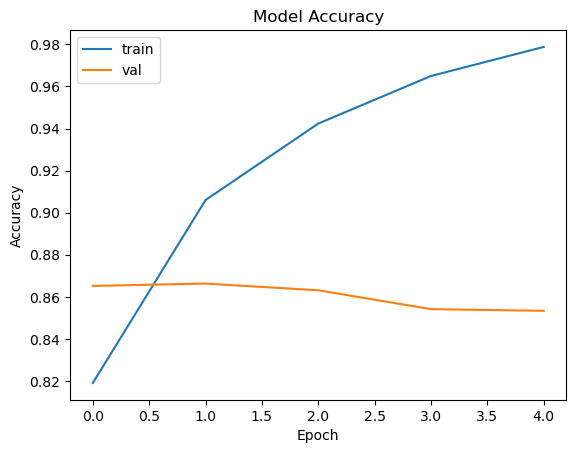

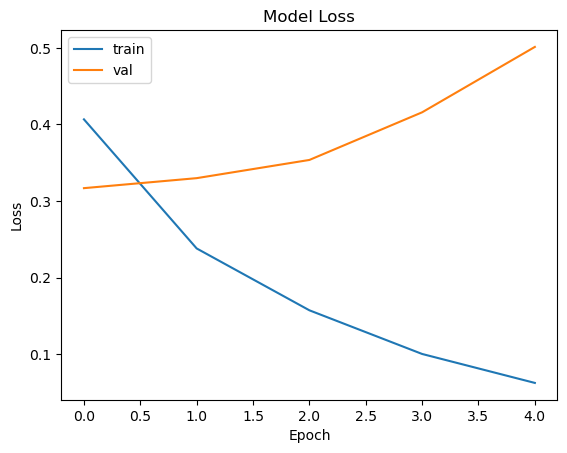

In [57]:
# Train the model and record the training history
history = model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs= 5, validation_data=(X_test_seq, y_test_seq))

# Plot the training accuracy vs validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training loss vs validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [58]:
#Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

782/782 [==============================] - 14s 18ms/step - loss: 0.5013 - accuracy: 0.8534
Test loss : 0.5013
Test accuracy : 0.8534


In [44]:
#new_review = "I really enjoyed this movie. The acting was great and the story kept me engaged."
#new_review = 'The movie was very bad, wasted my time.' 
new_review = " So I liked the movie, but I also thought it could be a lot better if some scenes were written better, but overall, it was a good experience"

new_review_seq = tokenizer.texts_to_sequences([new_review])
new_review_seq_padded = pad_sequences(new_review_seq, maxlen=maxlen)

prediction = model1.predict(new_review_seq_padded)
if prediction[0][0] > prediction[0][1]:
    print("Negative Review")
else:
    print("Positive Review")


1/1 [==============================] - 0s 32ms/step
Positive Review


In [51]:
from tensorflow.keras.models import load_model

file_path = 'LSTM_Mod.h5'

# Load the saved model
modeln = load_model(file_path)


new_review = " So I liked the movie, but I also thought it could be a lot better if some scenes were written better, but overall, it was a good experience"

new_review_seq = tokenizer.texts_to_sequences([new_review])
new_review_seq_padded = pad_sequences(new_review_seq, maxlen=maxlen)

prediction = modeln.predict(new_review_seq_padded)
if prediction[0][0] > prediction[0][1]:
    print("Negative Review")
else:
    print("Positive Review")


1/1 [==============================] - 0s 317ms/step
Positive Review
